<a href="https://colab.research.google.com/github/AmrMomtaz/Image-Segmentation/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition (SER)

## Installation and importing the data 

In this section all the project dependencies will be installed and we will import the data. You can find the dataset <a href="https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en">here</a>
You **MUST** import your kaggle API token to clone the data.

In [1]:
%%capture
# Cloning data
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
! unzip /content/speech-emotion-recognition-en.zip
! rm /content/speech-emotion-recognition-en.zip
! rm -rf /content/Ravdess
! rm -rf /content/Savee
! rm -rf /content/Tess

# Importing libraries
import numpy as np
import pandas as pd
import librosa, librosa.display
from IPython.core.display import display
import matplotlib.pyplot as plt
import IPython
import torch
from torch.utils.data import Dataset
import torchaudio

# Defining constants
SAMPLE_RATE = 22050 # Sample rate of the signal
NUM_SAMPLES = 55125 # Number of samples for each audio (2.5*22050)(2.5 secs)
FIG_SIZE = (9,6)

In [3]:
# Running GPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device

'cpu'

In [4]:
# getting audio paths
crema_files = !ls /content/Crema
data_list = list()
audio_df = []
for line in crema_files:
  for audio in line.split():
    path = '/content/Crema/'+audio
    label = audio.split('_')[2]
    duration = librosa.get_duration(filename=path)
    data_list.append((path,label))
    audio_df.append((audio,duration,label))
audio_df = pd.DataFrame(audio_df,columns = ['Name','Duration','Label'])
audio_df

,Name,Duration,Label
0,1001_DFA_ANG_XX.wav,2.275562,ANG
1,1031_IWL_ANG_XX.wav,2.602625,ANG
2,1061_TAI_HAP_XX.wav,2.502500,HAP
3,1001_DFA_DIS_XX.wav,2.335688,DIS
4,1031_IWL_DIS_XX.wav,2.869562,DIS
...,...,...,...
7437,1031_ITS_NEU_XX.wav,2.435750,NEU
7438,1061_TAI_DIS_XX.wav,2.936250,DIS
7439,1091_WSI_SAD_XX.wav,2.502500,SAD
7440,1031_ITS_SAD_XX.wav,2.335688,SAD


In [5]:
audio_df.describe()

,Duration
count,7442.000000
mean,2.542884
std,0.505979
min,1.267937
25%,2.202187
50%,2.502500
75%,2.836187
max,5.005000


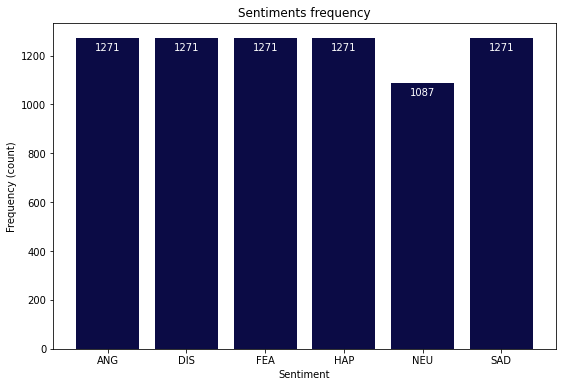

In [6]:
#@title
x,y = list(),list()
for group,frame in audio_df.groupby('Label'):
  x.append(group)
  y.append(len(frame))
plt.figure(figsize=FIG_SIZE)
plt.bar(x,y,color = (0.043,0.043,0.27))
plt.text(plt.xticks()[0][0],y[0]-50,y[0], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][1],y[1]-50,y[1], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][2],y[2]-50,y[2], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][3],y[3]-50,y[3], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][4],y[4]-50,y[4], ha = 'center' , color = 'white')
plt.text(plt.xticks()[0][5],y[5]-50,y[5], ha = 'center' , color = 'white')
plt.xlabel('Sentiment')
plt.ylabel('Frequency (count)')
plt.title('Sentiments frequency');

In [7]:
# Function which plots waveform and loads the audio for listening
def visualize_audio(audio_path):
  signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE)
  plt.figure(figsize=FIG_SIZE)
  librosa.display.waveplot(signal, sample_rate, alpha=0.8)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Waveform")
  plt.show();
  print('\n',end='')
  display(IPython.display.Audio(audio_path))

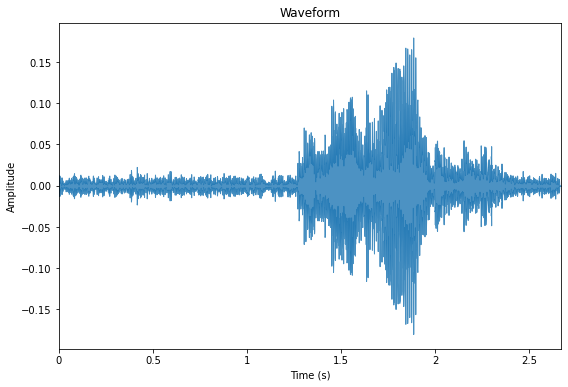

In [8]:
visualize_audio(data_list[700][0])

## Pre-processing data

In this section, We will preprocess and split the data. we'll provide two representation of the data which we will feed to the neural network for training.
* Frequency spectrogram with zero crossing rate and energy.
* Mel Sepctrogram.

Finally, we'll split the data into 70% training and validation (66.5% for training and 3.5% for validation) 30% for testing.

In [9]:
# Creating dataset class
class CremaDataset(Dataset):

    # data_list contains key as label and value is the audio path
    def __init__(self, data_list, transformation, target_sample_rate,
                 num_samples, device):
      self.data_list = data_list
      self.transformation = transformation.to(device)
      self.target_sample_rate = target_sample_rate
      self.num_samples = num_samples
      self.device = device

    def __len__(self):
      return len(self.data_list)
 
    # Truncating long signals
    def _cut(self, signal):
      if signal.shape[1] > self.num_samples:
          signal = signal[:, :self.num_samples]
      return signal

    # Padding short signals with zeros
    def _right_pad(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples:
          num_missing_samples = self.num_samples - length_signal
          last_dim_padding = (0, num_missing_samples)
          signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal

    # Resampling signal to make all signals have same target sample rate
    def _resample(self, signal, sr):
      if sr != self.target_sample_rate:
          resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
          signal = resampler(signal)
      return signal

    # Mixing down signal (Reducing number of channels)
    def _mix_down(self, signal):
      if signal.shape[0] > 1:
          signal = torch.mean(signal, dim=0, keepdim=True)
      return signal

    def __getitem__(self, index):
      label = self.data_list[index][1]
      signal, sr = torchaudio.load(self.data_list[index][0])
      signal = signal.to(self.device)
      signal = self._resample(signal, sr)
      signal = self._mix_down(signal)
      signal = self._cut(signal)
      signal = self._right_pad(signal)
      signal = self.transformation(signal)
      return signal, label

In [10]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

creama_dataset = CremaDataset(data_list,mel_spectrogram
                              ,SAMPLE_RATE,NUM_SAMPLES,device)